# Import

In [1]:
from pandas_data_reader_service_core.modules.finam.search_service import Search, Market
from pandas_data_reader_service_core.modules.finam.stock_info import FinamStockInfo
from pandas_data_reader_service_core.service import PandasDataReaderService as pdrs, StockInfo, TimeFrame
from datetime import date
import seaborn as sns
import pandas as pd
from typing import Tuple

# Build data

## Load data

In [2]:
eurusd_stock_list = Search.by_code("EURUSD", Market.CURRENCIES_WORLD)
eurusd_stock_list

,name,code,market
id,,,
83,Eur/Usd,EURUSD,5


In [3]:
eurusd_stock_info = StockInfo.init_for_Finam(FinamStockInfo(eurusd_stock_list.index[0]))
print(eurusd_stock_info)

Source StockSource.Finam source StockInfo Market 5 code EURUSD index 83


In [4]:
date_from = date(2015,1,1)
date_till = date(2020,2,1)
tf = TimeFrame.HOURLY

In [5]:
data_df = pdrs().get(stock=eurusd_stock_info,  date_from=date_from,date_to=date_till,time_frame=tf,short_col_name=True)
data_df

,O,H,L,C,V
DT,,,,,
2015-01-01 00:00:00,1.20986,1.21079,1.20970,1.21006,26264
2015-01-01 01:00:00,1.21005,1.21037,1.20960,1.21009,15605
2015-01-01 02:00:00,1.21016,1.21024,1.20950,1.21005,14092
2015-01-01 03:00:00,1.21003,1.21008,1.20948,1.20970,10195
2015-01-01 04:00:00,1.20971,1.21000,1.20948,1.20959,136
...,...,...,...,...,...
2020-01-31 21:00:00,1.10828,1.10836,1.10760,1.10799,69886
2020-01-31 22:00:00,1.10800,1.10902,1.10780,1.10894,78526
2020-01-31 23:00:00,1.10891,1.10919,1.10830,1.10904,56848


## Prepare data

### Column in rows

In [6]:
prepared_df = data_df.melt(id_vars=["V"], 
                            var_name="PT", 
                            value_name="PV")
len(prepared_df)

130744

In [7]:
prepared_df = prepared_df.groupby(["PT", "PV"]).sum().reset_index()
print(len(prepared_df))
prepared_df.head()

45788


,PT,PV,V
0,C,1.03558,108744
1,C,1.03696,101939
2,C,1.03713,102614
3,C,1.03739,142222
4,C,1.03766,107396


### Grouping

In [8]:
def split_into_group(from_v:float, till_v:float, group_count:int, round:int = 5)->Tuple[float, pd.DataFrame]:
    interval = (till_v - from_v)/group_count
    groups = []
    cur_gr_min = from_v
    cur_gr_max = cur_gr_min+interval
    idx = 1
    while idx < group_count:
        groups.append((cur_gr_min, cur_gr_max))
        cur_gr_min = cur_gr_max
        cur_gr_max = cur_gr_min+interval
        idx = idx + 1 
    groups.append((cur_gr_min, till_v))
    groups_df = pd.DataFrame(groups, columns =['From', 'Till'])
    groups_df["GR"] = groups_df.round(round)[["From","Till"]].apply(tuple,axis=1)
    return interval, groups_df

In [9]:
group_count = 100

In [10]:
min_pv = prepared_df["PV"].min()
max_pv = prepared_df["PV"].max()
interval, groups = split_into_group(min_pv, max_pv, group_count)
print(f'min = {min_pv}, max = {max_pv}, interval = {interval}')
groups

min = 1.03394, max = 1.25556, interval = 0.0022161999999999993


,From,Till,GR
0,1.033940,1.036156,"(1.03394, 1.03616)"
1,1.036156,1.038372,"(1.03616, 1.03837)"
2,1.038372,1.040589,"(1.03837, 1.04059)"
3,1.040589,1.042805,"(1.04059, 1.0428)"
4,1.042805,1.045021,"(1.0428, 1.04502)"
...,...,...,...
95,1.244479,1.246695,"(1.24448, 1.2467)"
96,1.246695,1.248911,"(1.2467, 1.24891)"
97,1.248911,1.251128,"(1.24891, 1.25113)"
98,1.251128,1.253344,"(1.25113, 1.25334)"


In [11]:
def pvg_factory(pv):
    find_groups = groups["GR"][groups["GR"].apply(lambda gr: pv > gr[0] and pv <= gr[1])]
    if len(find_groups) != 1:
        if pv == groups["GR"][0][0]:
            return groups["GR"][0]
        raise Exception(f"Cann't define group for value {pv}, get {len(find_groups)} groups")
    try:
        return find_groups.iloc[0]
    except:
        raise Exception(f"Cann't define group for value {pv}, get {len(find_groups)} groups")

In [12]:
prepared_df["PVG"] = prepared_df["PV"].apply(lambda pv: pvg_factory(pv))
prepared_df

,PT,PV,V,PVG
0,C,1.03558,108744,"(1.03394, 1.03616)"
1,C,1.03696,101939,"(1.03616, 1.03837)"
2,C,1.03713,102614,"(1.03616, 1.03837)"
3,C,1.03739,142222,"(1.03616, 1.03837)"
4,C,1.03766,107396,"(1.03616, 1.03837)"
...,...,...,...,...
45783,O,1.25380,49017,"(1.25334, 1.25556)"
45784,O,1.25381,97892,"(1.25334, 1.25556)"
45785,O,1.25392,94039,"(1.25334, 1.25556)"
45786,O,1.25485,52679,"(1.25334, 1.25556)"


### Define group volumes

In [13]:
prepared_df["PVGstr"] = prepared_df["PVG"].apply(lambda x: "-".join(map(str,x)))
prepared_df

,PT,PV,V,PVG,PVGstr
0,C,1.03558,108744,"(1.03394, 1.03616)",1.03394-1.03616
1,C,1.03696,101939,"(1.03616, 1.03837)",1.03616-1.03837
2,C,1.03713,102614,"(1.03616, 1.03837)",1.03616-1.03837
3,C,1.03739,142222,"(1.03616, 1.03837)",1.03616-1.03837
4,C,1.03766,107396,"(1.03616, 1.03837)",1.03616-1.03837
...,...,...,...,...,...
45783,O,1.25380,49017,"(1.25334, 1.25556)",1.25334-1.25556
45784,O,1.25381,97892,"(1.25334, 1.25556)",1.25334-1.25556
45785,O,1.25392,94039,"(1.25334, 1.25556)",1.25334-1.25556
45786,O,1.25485,52679,"(1.25334, 1.25556)",1.25334-1.25556


In [14]:
grouped_df = prepared_df[["PVGstr","PT","V"]].groupby(["PT","PVGstr"]).sum().reset_index()
grouped_df

,PT,PVGstr,V
0,C,1.03394-1.03616,108744
1,C,1.03616-1.03837,661200
2,C,1.03837-1.04059,3174637
3,C,1.04059-1.0428,3709955
4,C,1.0428-1.04502,6256460
...,...,...,...
394,O,1.24448-1.2467,4508454
395,O,1.2467-1.24891,2519836
396,O,1.24891-1.25113,2511358
397,O,1.25113-1.25334,361562


# Analitic

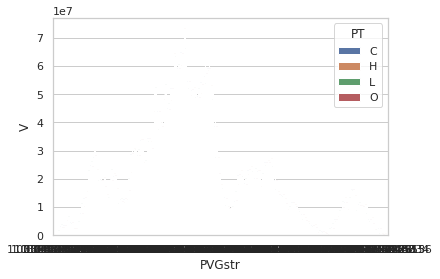

In [15]:
# Draw a nested barplot by species and sex
g = sns.barplot(
    data=grouped_df, 
    x="PVGstr", y="V", hue="PT"
)